# LLM Fact Maker: Zero Shot Prompts

In [ ]:
# !pip install -U torch
# Install vLLM from pip:
# !pip install transformers==4.44.2
!pip install matplotlib


# Operational Section

This section is just used to get the model up and running and test it. I ran on a local jupyter server because the collabs server took way too long and I have a cuda capable GPU.

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

torch.random.manual_seed(0)
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)

tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

messages = [
    {"role": "system", "content": "You are a helpful AI assistant. What type of questions can you answer?"}
]

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

generation_args = {
    "max_new_tokens": 500,
    "return_full_text": False,
    "temperature": 0.0,
    "do_sample": False,
}

output = pipe(messages, **generation_args)
print(output[0]['generated_text'])


In [ ]:
import json

# Load nouns from file
with open("/Users/eleme/One Shot Prompt/nouns.txt", "r") as f:
    nouns = [line.strip() for line in f if line.strip()]

# Load properties from file
with open("/Users/eleme/One Shot Prompt/properties.txt", "r") as f:
    properties = [line.strip() for line in f if line.strip()]

# Function to generate a baseline prompt for a property
def make_prompt(property_name: str) -> dict:
    return {
        "pre-prompt": f"Output ONLY a number from 1 to 10. How {property_name} would you rate this noun: ",
        "property": property_name
    }

# Generate baseline prompts (one line per property, not per noun!)
baseline_prompts = [make_prompt(prop) for prop in properties]

# Write out to JSONL file
with open("/Users/eleme/One Shot Prompt/baseline-prompts.jsonl", "w") as f:
    for entry in baseline_prompts:
        f.write(json.dumps(entry) + "\n")

print(f"baseline-prompts.jsonl created with {len(baseline_prompts)} properties.")


# Testing the LLM Pipeline

In [ ]:
# Testing
import json

# Load nouns
with open("/Users/eleme/One Shot Prompt/nouns.txt", "r") as f:
    nouns = [line.strip() for line in f if line.strip()]

# Load baseline prompts
with open("/Users/eleme/One Shot Prompt/baseline-prompts.jsonl", "r") as f:
    prompts = [json.loads(line) for line in f]

def batched_debug_run(pipe, generation_args, nouns, prompts, batch_size=4):
    for prop in prompts:
        property_name = prop["property"]
        pre = prop["pre-prompt"]

        print(f"\n=== PROPERTY: {property_name.upper()} ===")

        for i in range(0, len(nouns), batch_size):
            batch_nouns = nouns[i:i+batch_size]
            batch_prompts = [pre + noun for noun in batch_nouns]

            outs = pipe(batch_prompts, **generation_args)

            # If the pipeline duplicated output, detect it
            if len(outs) != len(batch_prompts):
                print(f"⚠️ Mismatch: {len(batch_prompts)} prompts but {len(outs)} outputs. Possible duplication.")
                # fall back to sequential
                outs = [pipe(p, **generation_args)[0] for p in batch_prompts]

            for noun, prompt, out in zip(batch_nouns, batch_prompts, outs):
                text = (
                    out[0]["generated_text"]
                    if isinstance(out, list) and "generated_text" in out[0]
                    else out.get("generated_text", str(out))
                    if isinstance(out, dict)
                    else str(out)
                )
                print(f"[PROMPT SENT] {prompt}")
                print(f"[NOUN]        {noun}")
                print(f"[OUTPUT]      {text.strip()}\n")


# Run the strict debug printer
batched_debug_run(pipe, generation_args, nouns, prompts, batch_size=4)


# Property Assessment

We now have all of the required files generated to run the prompts for assessment.

Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.07it/s]



🔍 Assessing property: weight


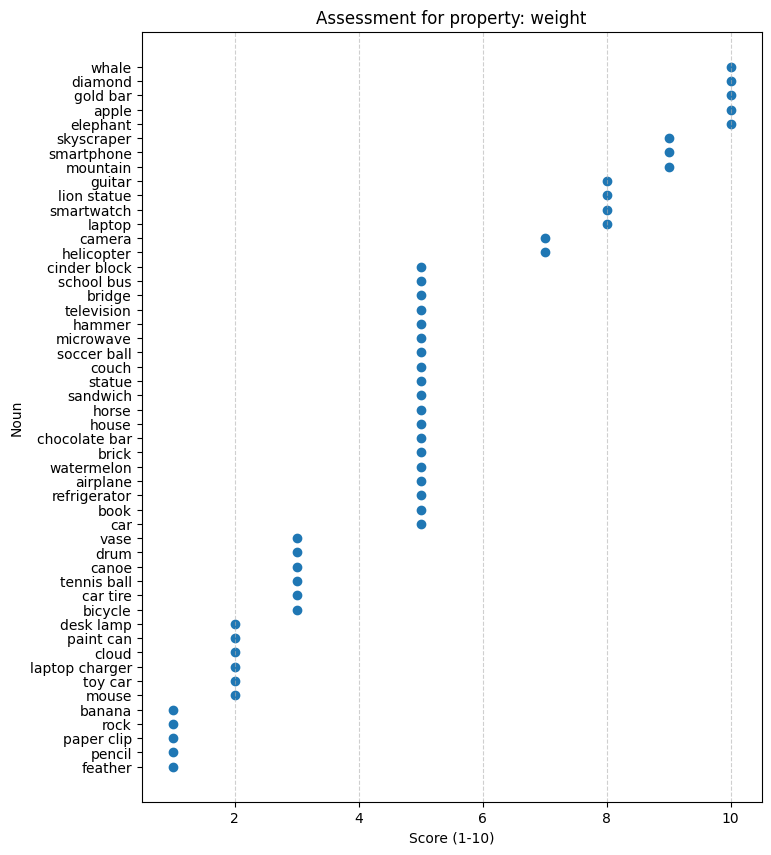


🔍 Assessing property: size


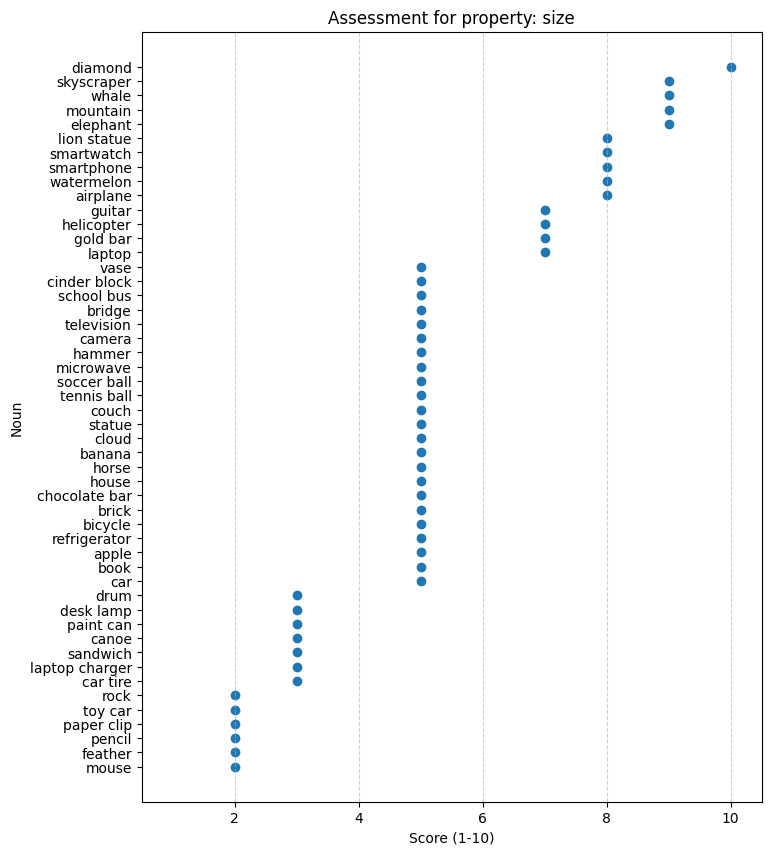


🔍 Assessing property: strength


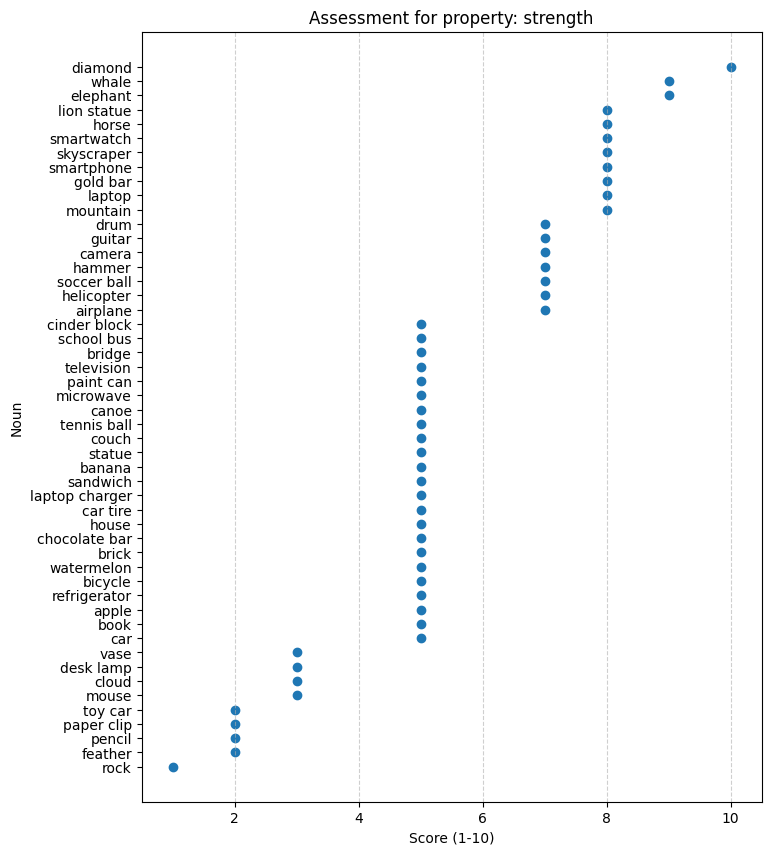


🔍 Assessing property: speed


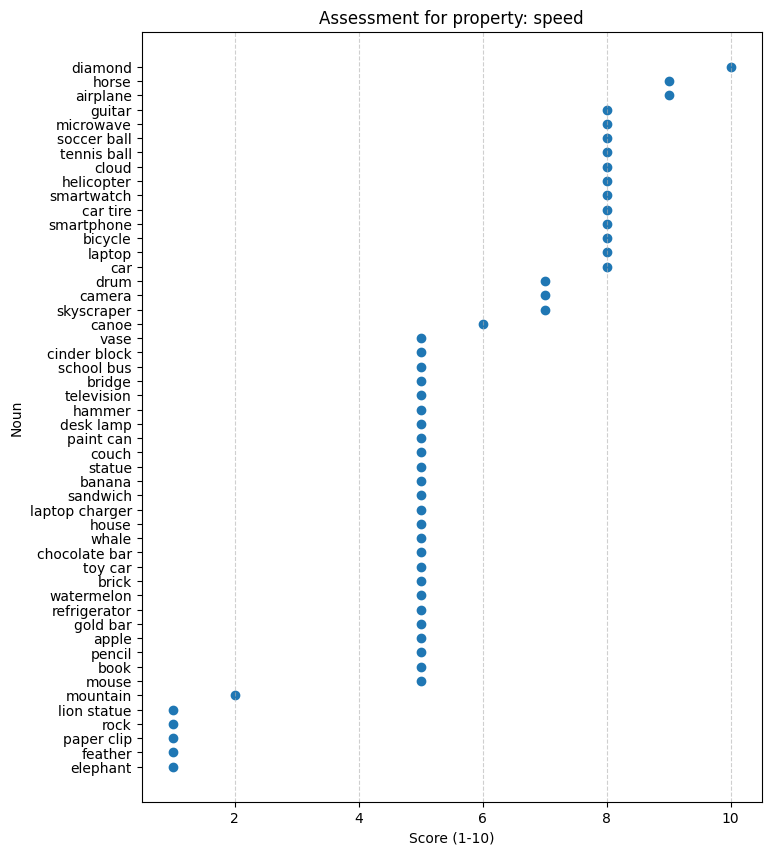


🔍 Assessing property: complexity


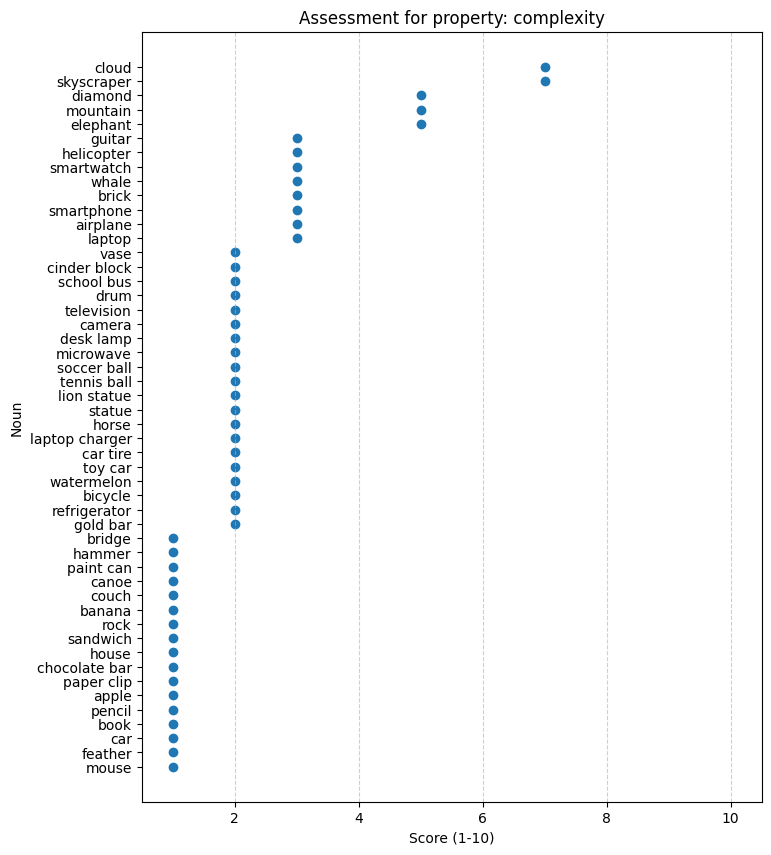


🔍 Assessing property: usefulness


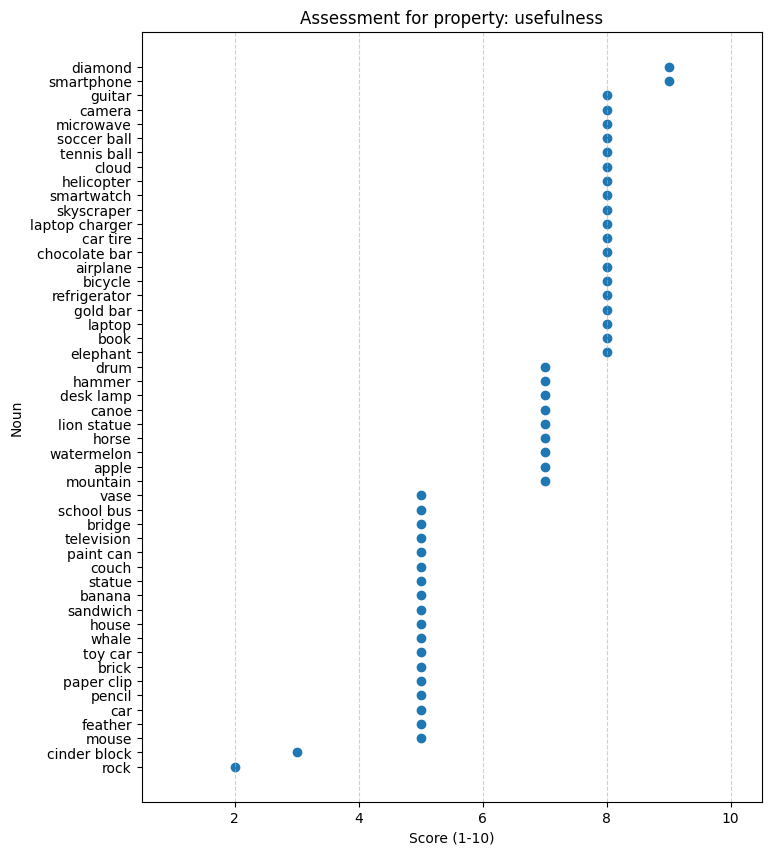


🔍 Assessing property: danger


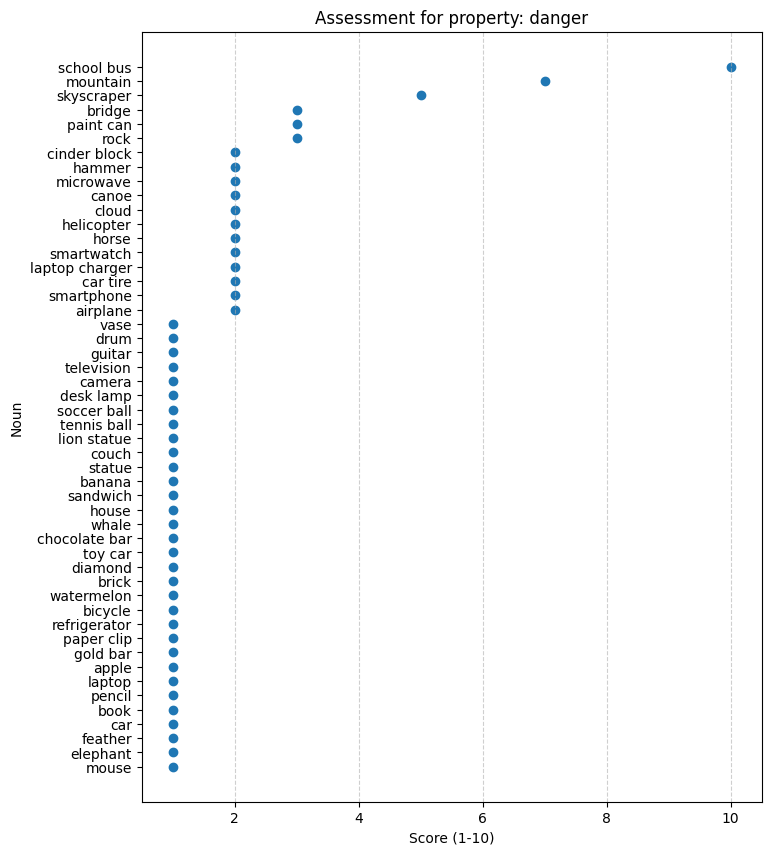


🔍 Assessing property: popularity


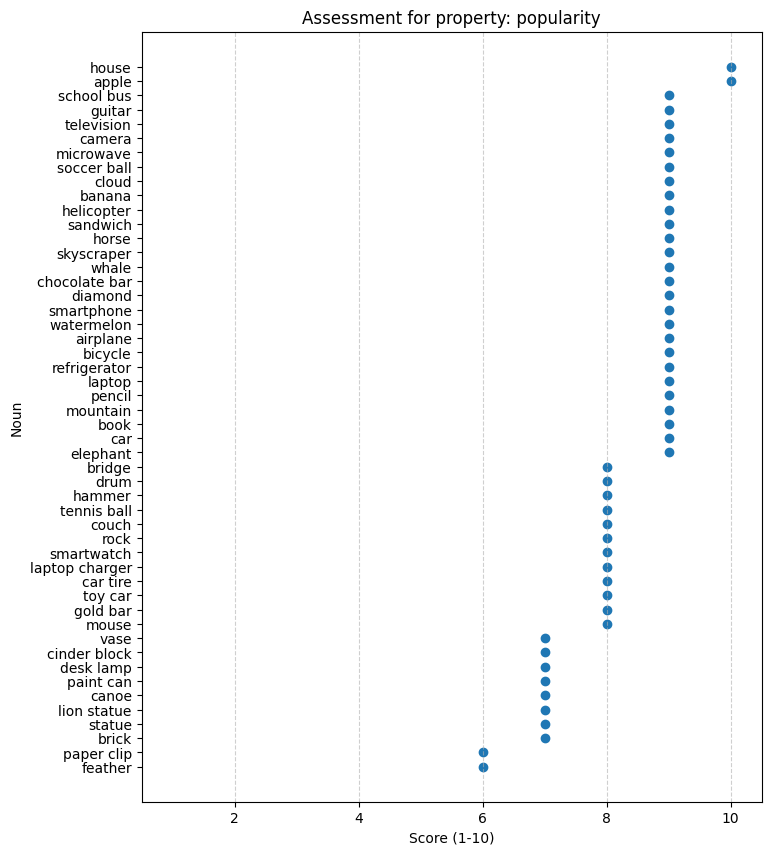

In [4]:
import json
import re
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# --- Load nouns ---
with open("/Users/eleme/One Shot Prompt/nouns.txt", "r") as f:
    nouns = [line.strip() for line in f if line.strip()]

# --- Load baseline prompts ---
with open("/Users/eleme/One Shot Prompt/baseline-prompts.jsonl", "r") as f:
    prompts = [json.loads(line) for line in f]

# --- Load model & tokenizer (direct, no pipeline) ---
model_name = "microsoft/phi-3-mini-4k-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
).eval()

# --- Run model helper (generate-based) ---
def assess_property(property_entry, nouns):
    results = {}
    prompts = [property_entry["pre-prompt"] + noun for noun in nouns]

    # Tokenize
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(model.device)

    # Generate more tokens to allow full JSON
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=15,   # enough for {"score": 10}
            do_sample=False,
            temperature=0.0,
            pad_token_id=tokenizer.eos_token_id
        )

    # Decode row by row
    for i, noun in enumerate(nouns):
        new_tokens = outputs[i, inputs["input_ids"].shape[1]:]
        text = tokenizer.decode(new_tokens, skip_special_tokens=True).strip()

        score = None
        try:
            data = json.loads(text)
            score = int(data.get("score"))
        except Exception:
            # fallback: regex
            match = re.search(r"\b(10|[1-9])\b", text)
            if match:
                score = int(match.group(1))

        results[noun] = score

    return results


# --- Visualization helper ---
def plot_property_assessment(property_name, results):
    """
    Makes a dot plot for a single property.
    """
    sorted_items = sorted([(n, s) for n, s in results.items() if s is not None], key=lambda x: x[1])
    if not sorted_items:
        print(f"No valid results for {property_name}")
        return

    nouns_sorted, scores_sorted = zip(*sorted_items)

    plt.figure(figsize=(8, max(6, len(nouns_sorted) * 0.2)))
    plt.scatter(scores_sorted, nouns_sorted)
    plt.xlabel("Score (1-10)")
    plt.ylabel("Noun")
    plt.title(f"Assessment for property: {property_name}")
    plt.xlim(0.5, 10.5)
    plt.grid(axis="x", linestyle="--", alpha=0.6)
    plt.show()

# --- Main loop ---
all_results = {}
for prop in prompts:
    property_name = prop["property"]
    print(f"\n🔍 Assessing property: {property_name}")
    results = assess_property(prop, nouns)
    all_results[property_name] = results
    plot_property_assessment(property_name, results)



# Prompt Improvements

Now we will improve the prompt to get better results over baseline. Although, it seems like the baseline has been improved drastically at the same time as getting the baseline to reliably return only integers, so the gains may be minimal.

Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.04it/s]



🔍 Assessing property: weight


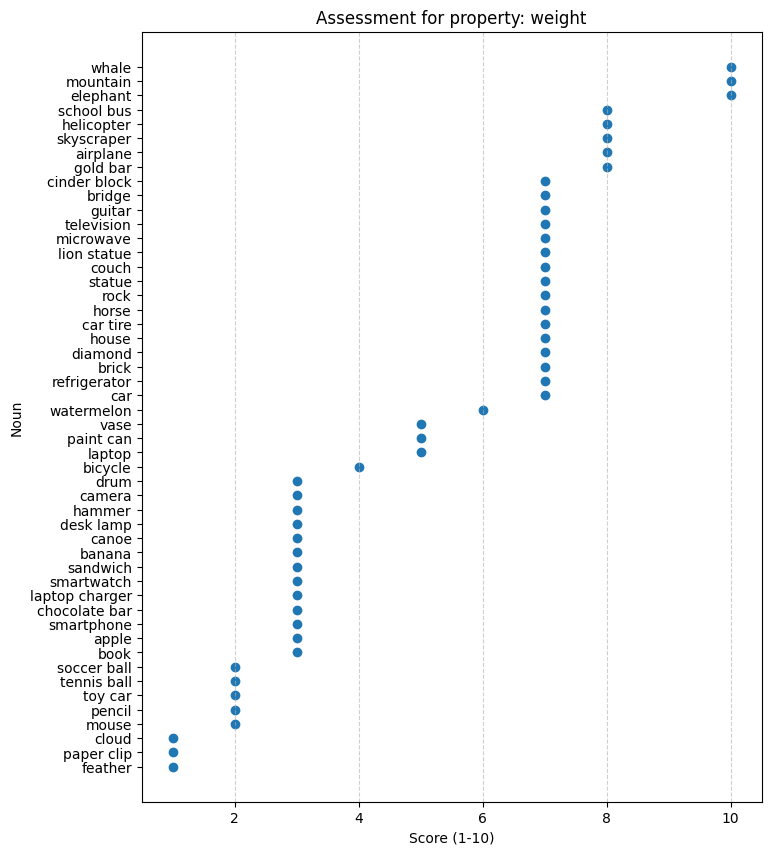


🔍 Assessing property: size


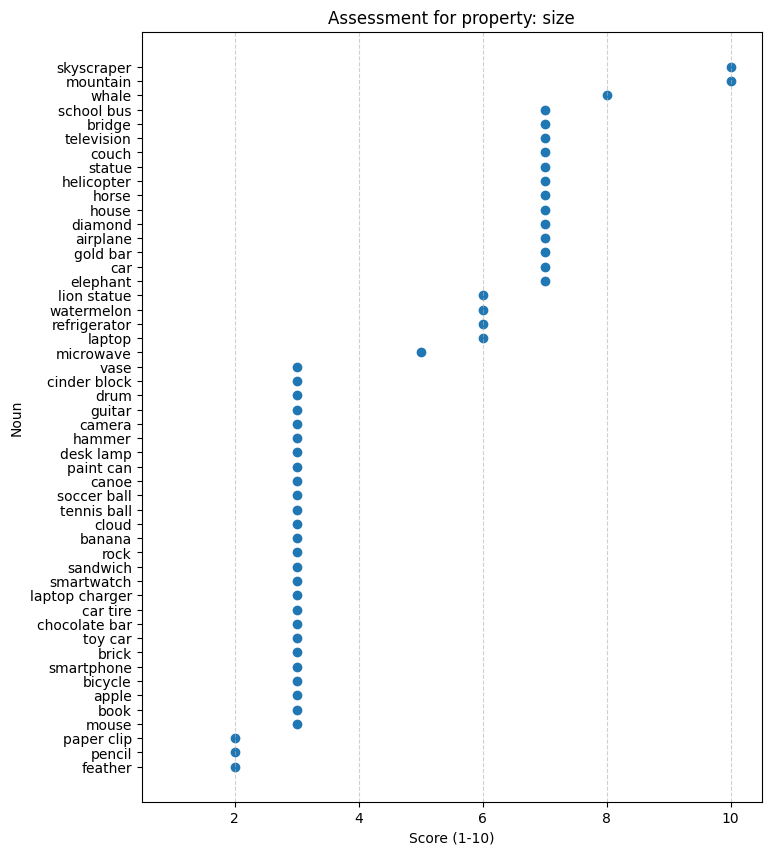


🔍 Assessing property: strength


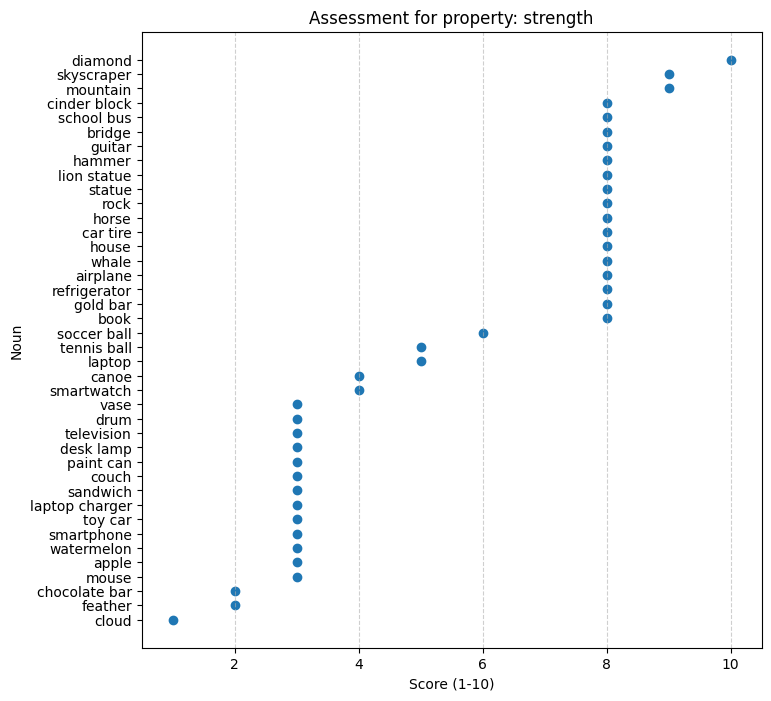


🔍 Assessing property: speed


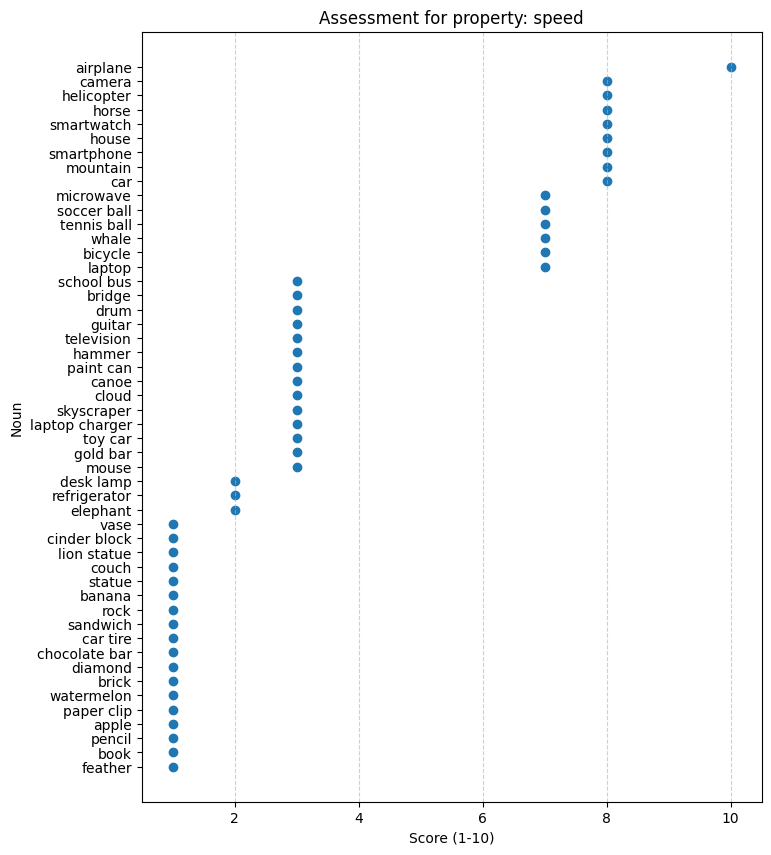


🔍 Assessing property: complexity


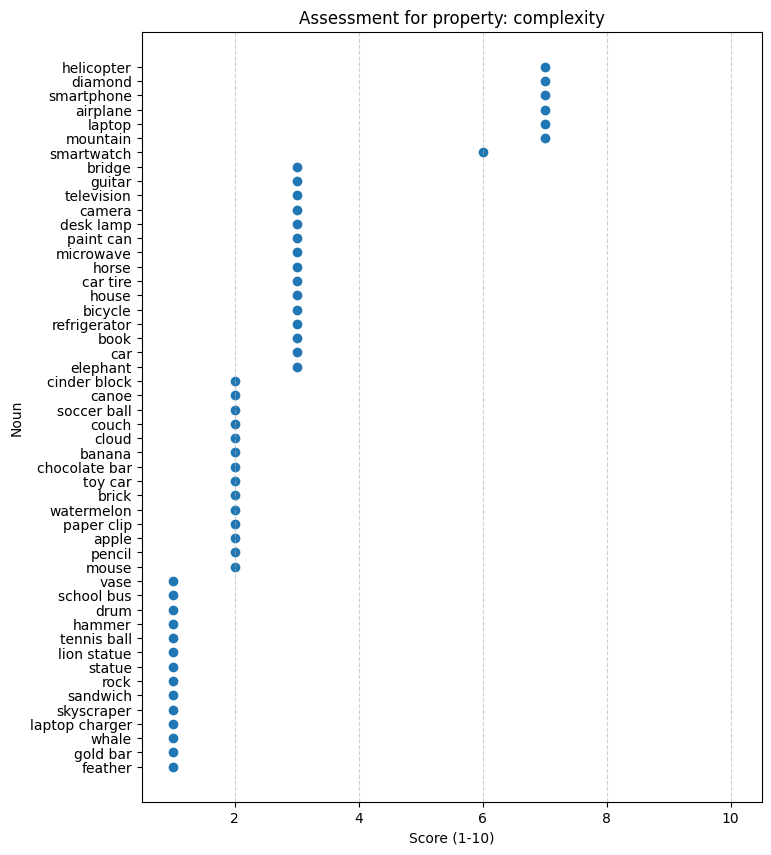


🔍 Assessing property: usefulness


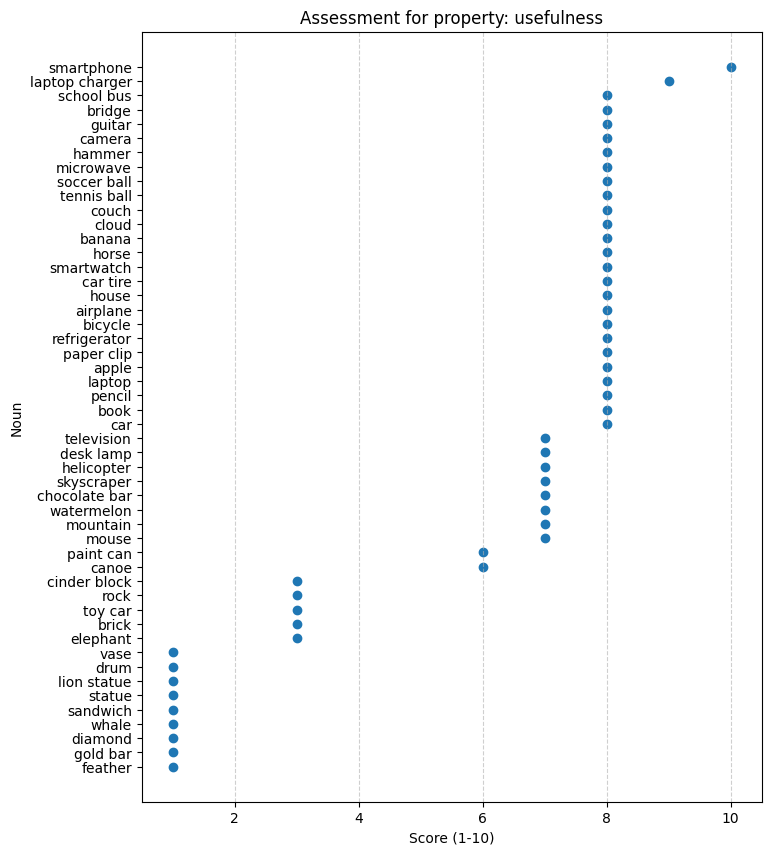


🔍 Assessing property: danger


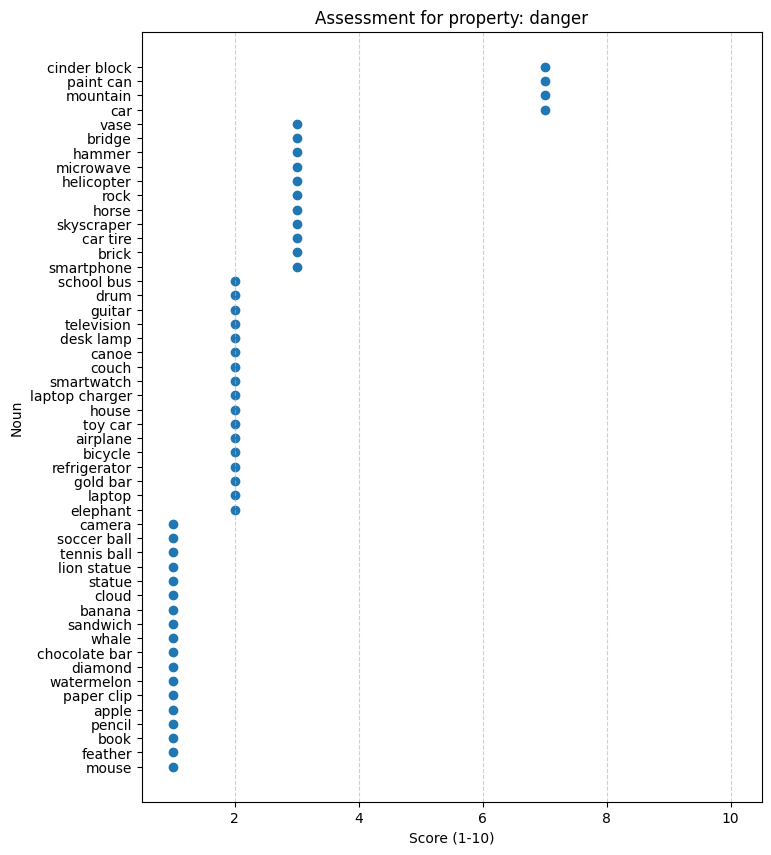


🔍 Assessing property: popularity


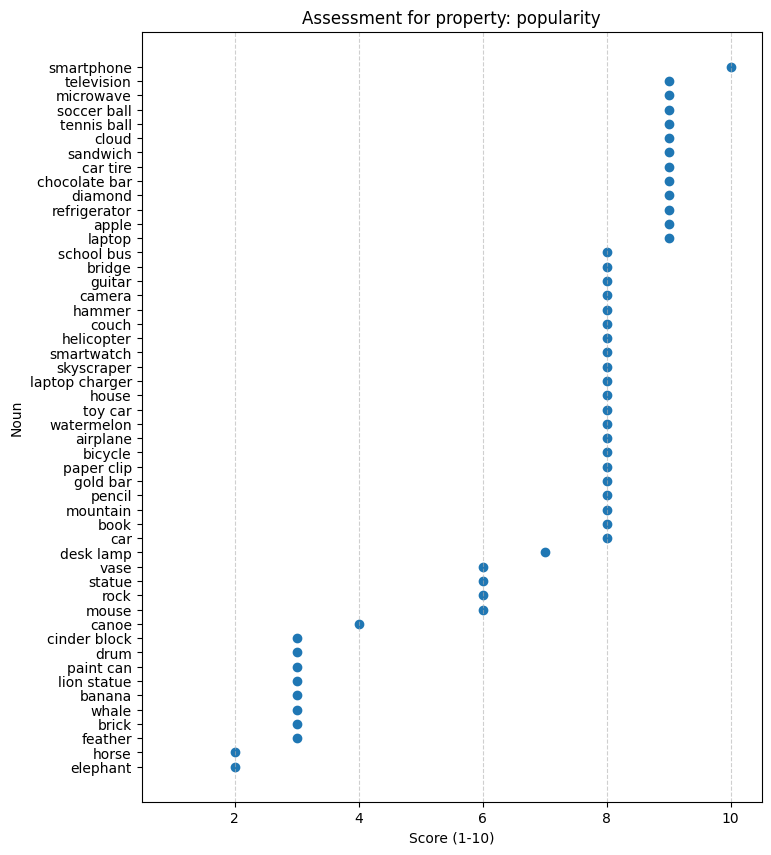

In [12]:
import json
import re
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# --- Load nouns ---
with open("/Users/eleme/One Shot Prompt/nouns.txt", "r") as f:
    nouns = [line.strip() for line in f if line.strip()]

# --- Load baseline prompts ---
with open("/Users/eleme/One Shot Prompt/improved-prompts.jsonl", "r") as f:
    prompts = [json.loads(line) for line in f]

# --- Load model & tokenizer (direct, no pipeline) ---
model_name = "microsoft/phi-3-mini-4k-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
).eval()

# --- Run model helper (generate-based) ---
def assess_property(property_entry, nouns):
    results = {}
    prompts = [property_entry["pre-prompt"] + noun for noun in nouns]

    # Tokenize
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(model.device)

    # Generate more tokens to allow full JSON
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=15,   # enough for {"score": 10}
            do_sample=False,
            temperature=0.0,
            pad_token_id=tokenizer.eos_token_id
        )

    # Decode row by row
    for i, noun in enumerate(nouns):
        new_tokens = outputs[i, inputs["input_ids"].shape[1]:]
        text = tokenizer.decode(new_tokens, skip_special_tokens=True).strip()

        score = None
        try:
            data = json.loads(text)
            score = int(data.get("score"))
        except Exception:
            # fallback: regex
            match = re.search(r"\b(10|[1-9])\b", text)
            if match:
                score = int(match.group(1))

        results[noun] = score

    return results


# --- Visualization helper ---
def plot_property_assessment(property_name, results):
    """
    Makes a dot plot for a single property.
    """
    sorted_items = sorted([(n, s) for n, s in results.items() if s is not None], key=lambda x: x[1])
    if not sorted_items:
        print(f"No valid results for {property_name}")
        return

    nouns_sorted, scores_sorted = zip(*sorted_items)

    plt.figure(figsize=(8, max(6, len(nouns_sorted) * 0.2)))
    plt.scatter(scores_sorted, nouns_sorted)
    plt.xlabel("Score (1-10)")
    plt.ylabel("Noun")
    plt.title(f"Assessment for property: {property_name}")
    plt.xlim(0.5, 10.5)
    plt.grid(axis="x", linestyle="--", alpha=0.6)
    plt.show()

# --- Main loop ---
all_results = {}
for prop in prompts:
    property_name = prop["property"]
    print(f"\n🔍 Assessing property: {property_name}")
    results = assess_property(prop, nouns)
    all_results[property_name] = results
    plot_property_assessment(property_name, results)

# Comaring Base to Improved


Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.14it/s]
Some parameters are on the meta device because they were offloaded to the cpu.



🔍 Assessing property: weight


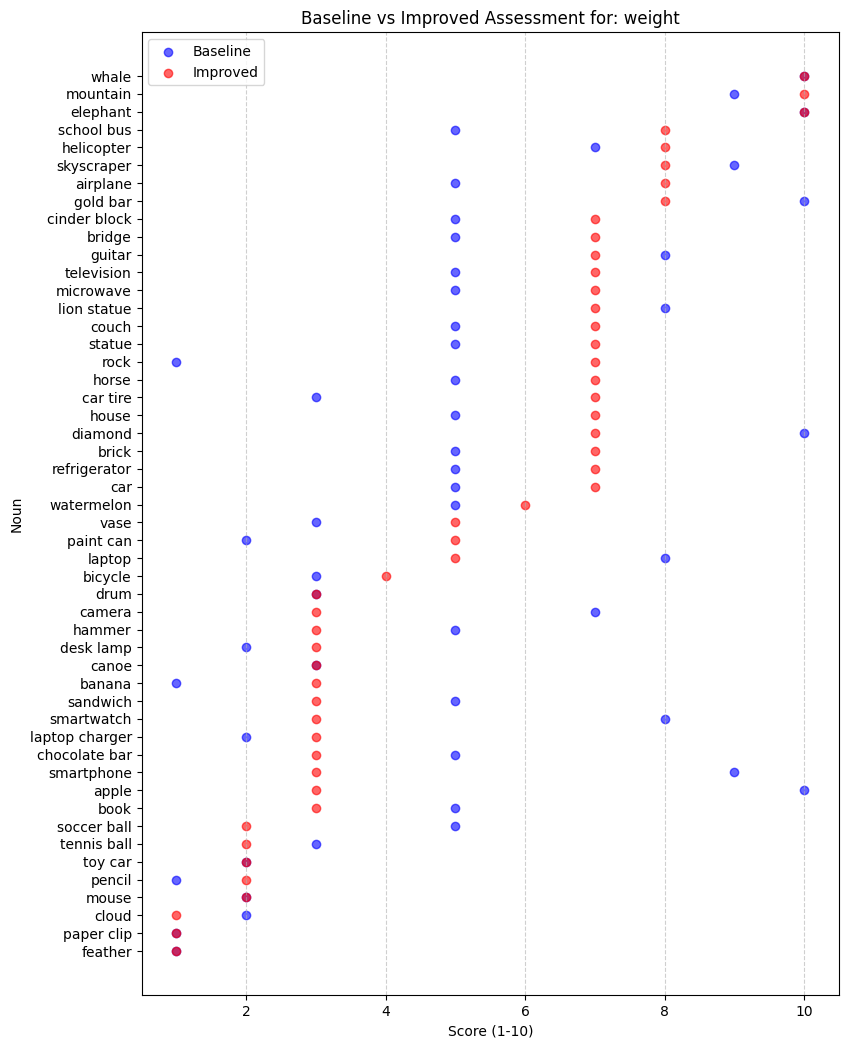


🔍 Assessing property: size


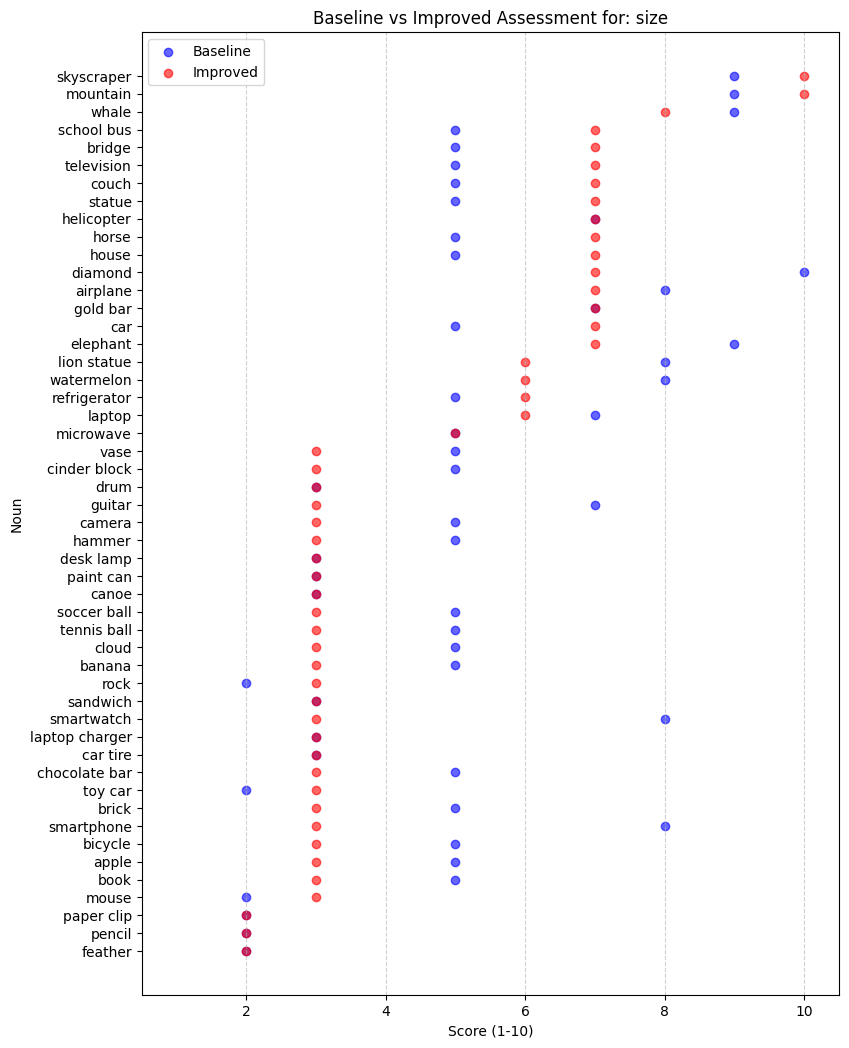


🔍 Assessing property: strength


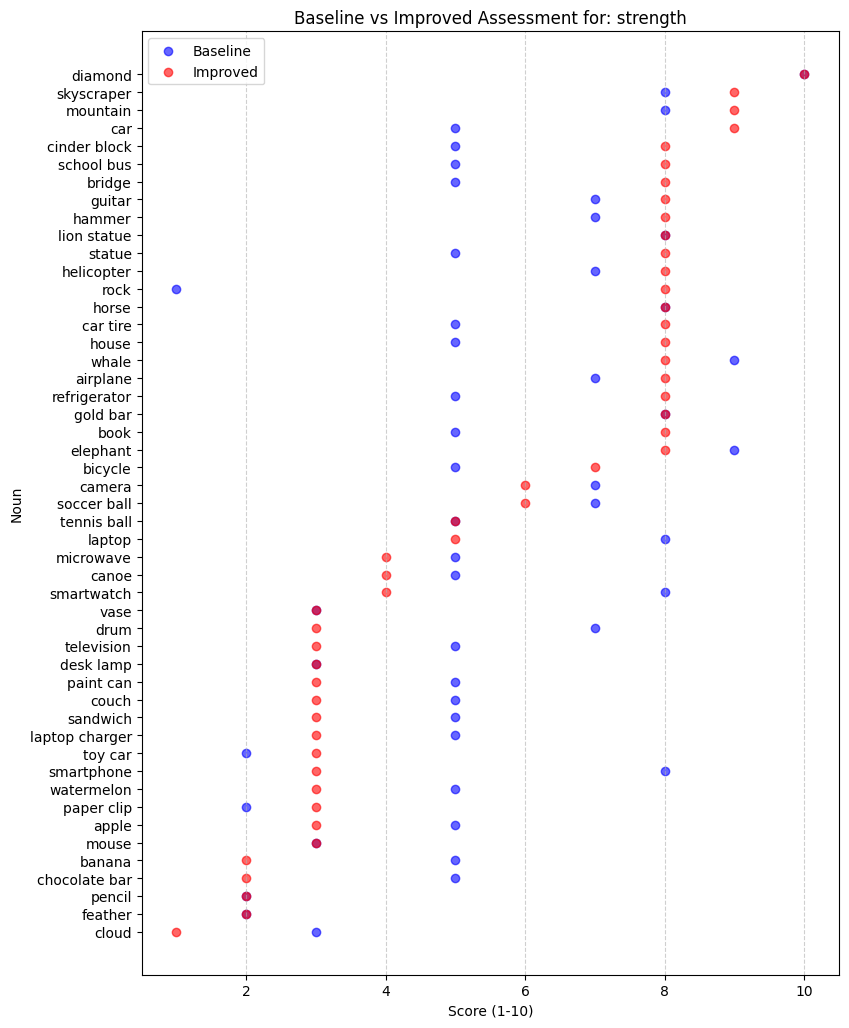


🔍 Assessing property: speed


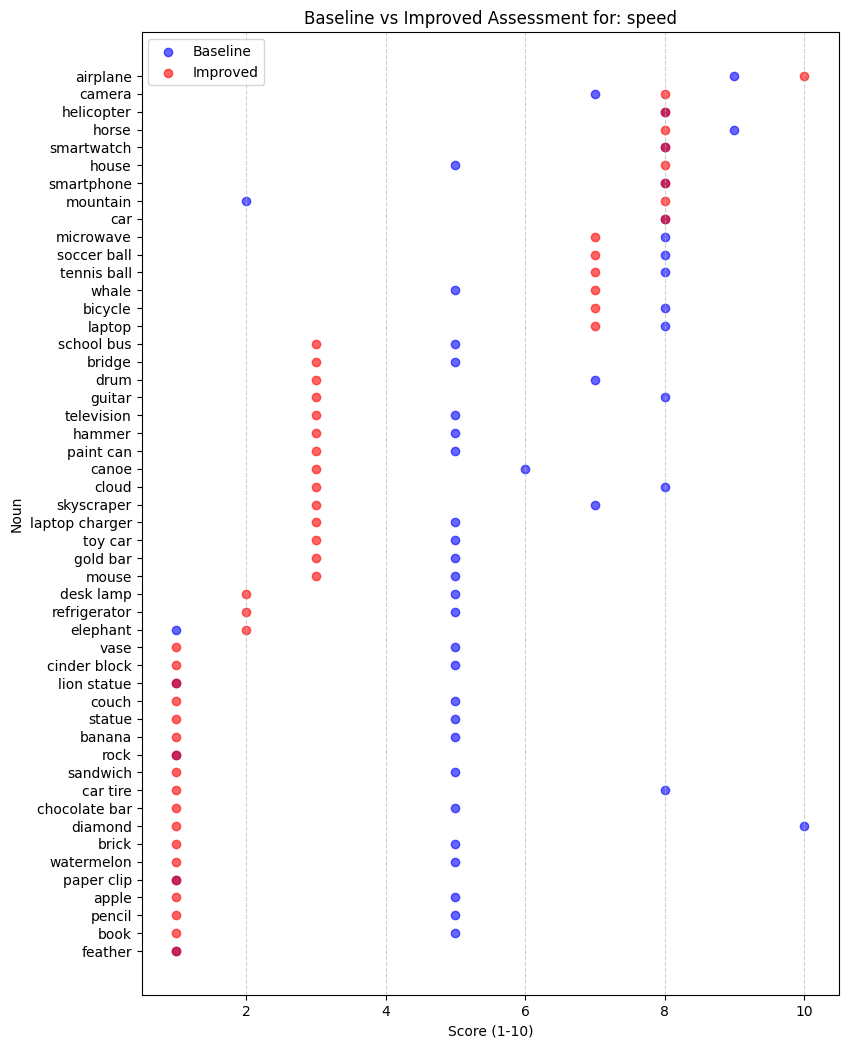


🔍 Assessing property: complexity


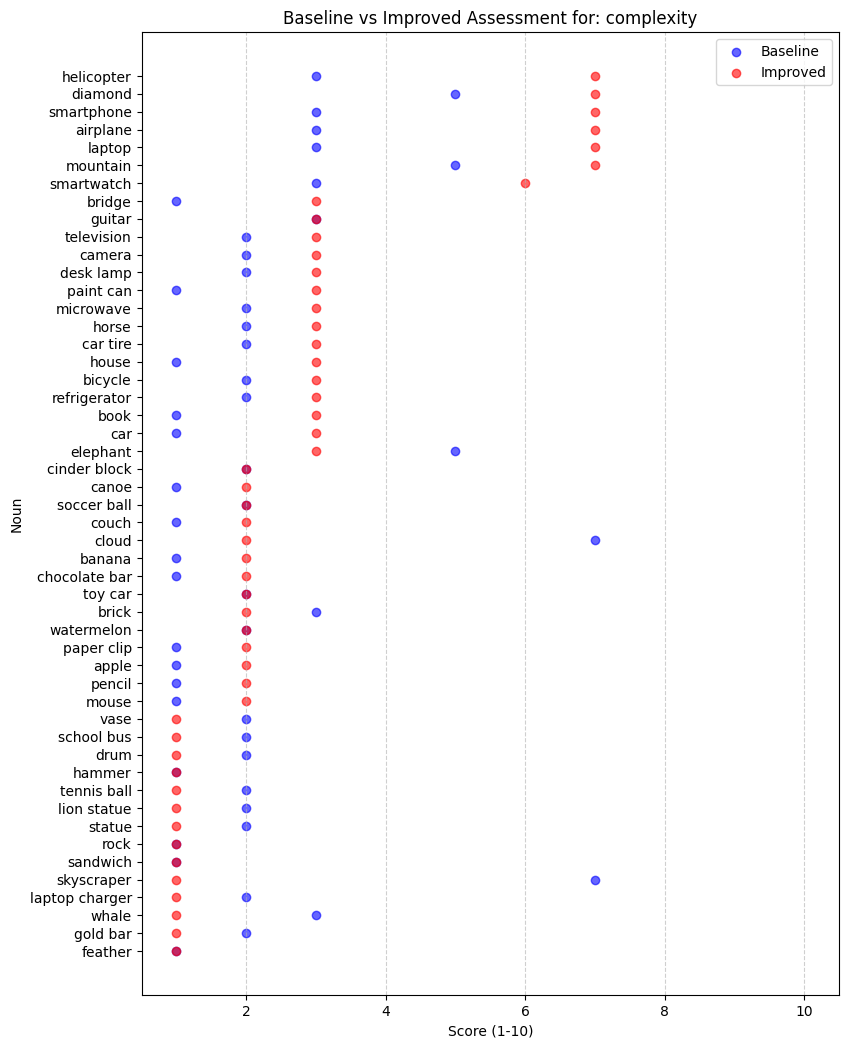


🔍 Assessing property: usefulness


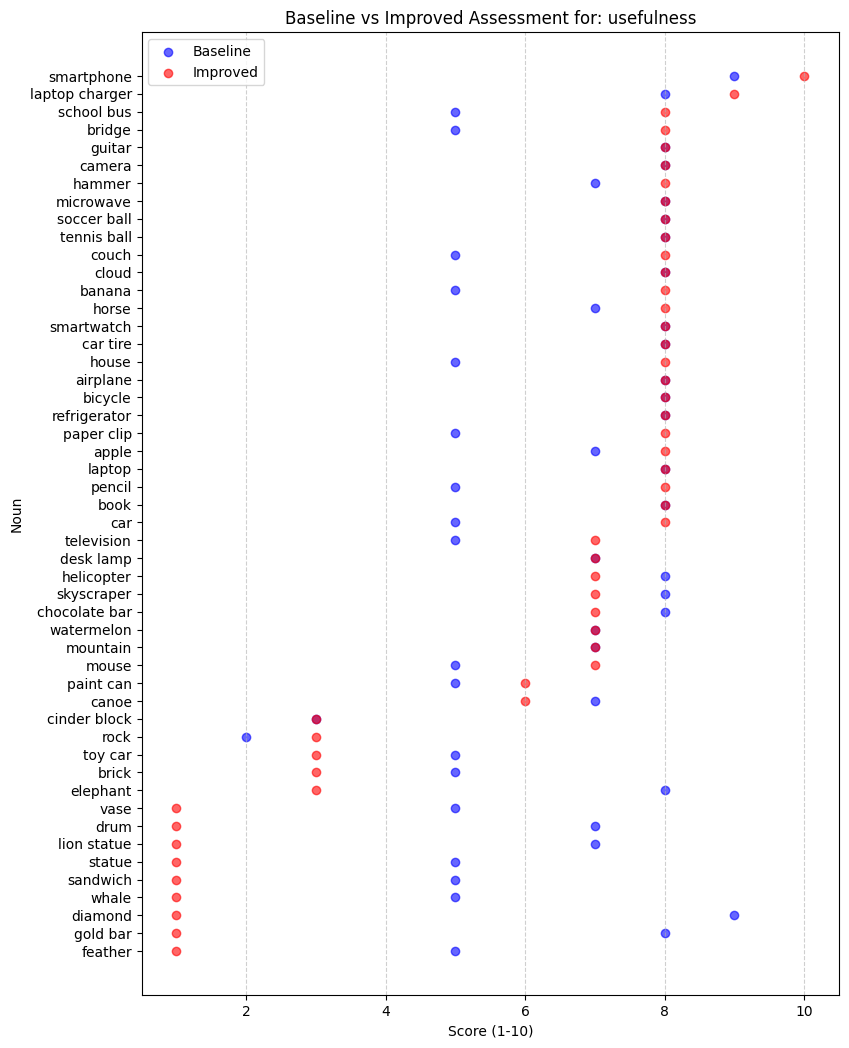


🔍 Assessing property: danger


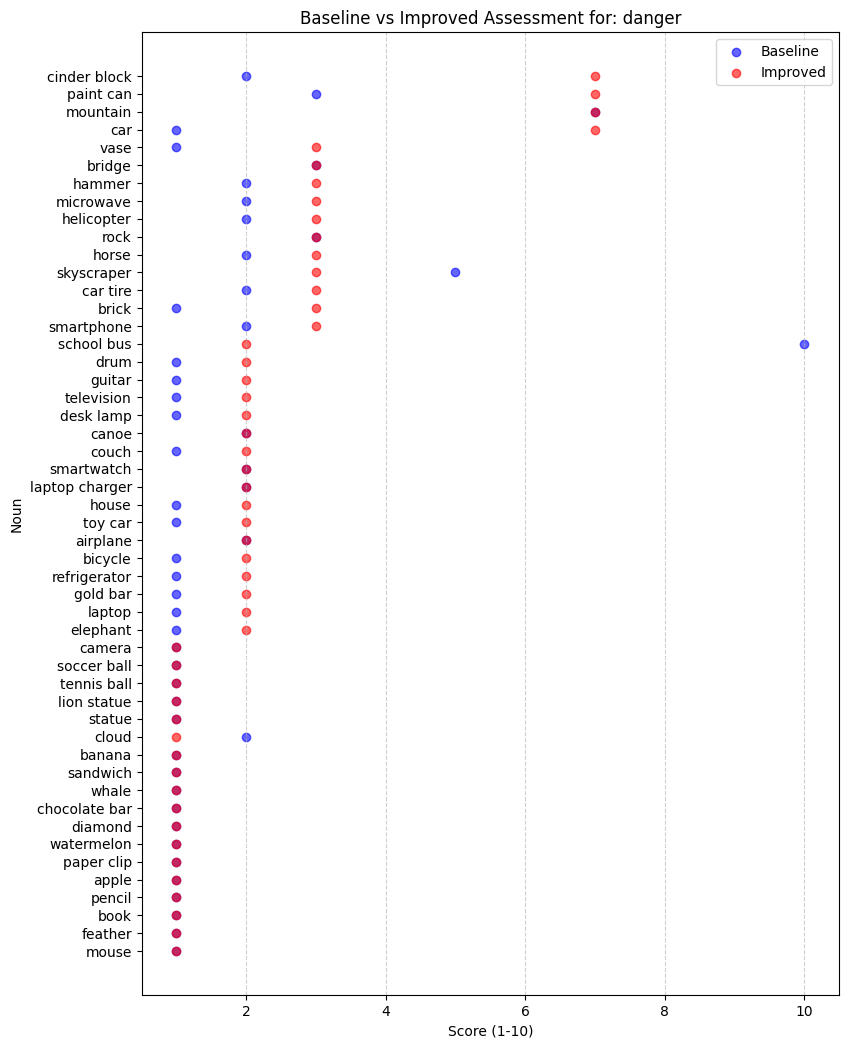


🔍 Assessing property: popularity


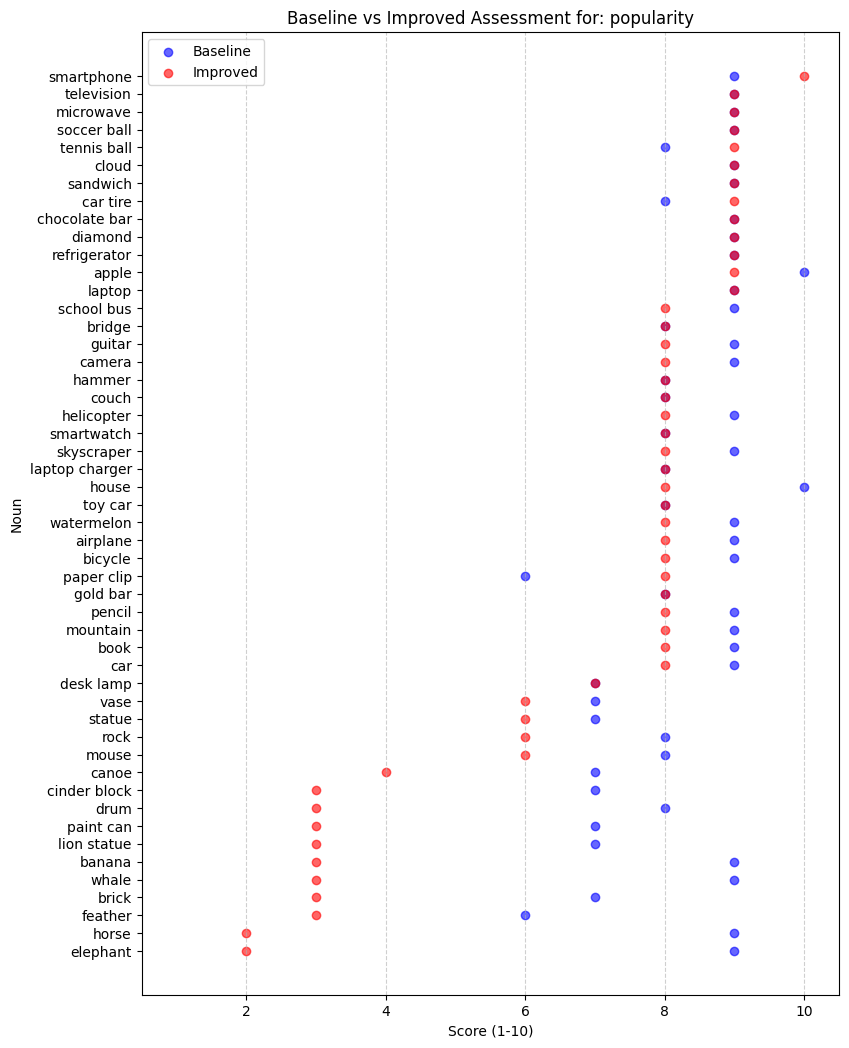

In [13]:
import json
import re
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# --- Load nouns ---
with open("/Users/eleme/One Shot Prompt/nouns.txt", "r") as f:
    nouns = [line.strip() for line in f if line.strip()]

# --- Load prompts ---
with open("/Users/eleme/One Shot Prompt/baseline-prompts.jsonl", "r") as f:
    baseline_prompts = [json.loads(line) for line in f]

with open("/Users/eleme/One Shot Prompt/improved-prompts.jsonl", "r") as f:
    improved_prompts = [json.loads(line) for line in f]

# --- Load model & tokenizer ---
model_name = "microsoft/phi-3-mini-4k-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
).eval()

# --- Run model helper ---
def assess_property(property_entry, nouns):
    results = {}
    prompts = [property_entry["pre-prompt"] + noun for noun in nouns]

    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=20,   # allow room for JSON
            do_sample=False,
            temperature=0.0,
            pad_token_id=tokenizer.eos_token_id
        )

    for i, noun in enumerate(nouns):
        new_tokens = outputs[i, inputs["input_ids"].shape[1]:]
        text = tokenizer.decode(new_tokens, skip_special_tokens=True).strip()

        score = None
        try:
            data = json.loads(text)
            score = int(data.get("score"))
        except Exception:
            match = re.search(r"\b(10|[1-9])\b", text)
            if match:
                score = int(match.group(1))

        results[noun] = score

    return results

# --- Visualization helper ---
def plot_property_comparison(property_name, baseline_results, improved_results):
    items = []
    for noun in nouns:
        b = baseline_results.get(noun)
        i = improved_results.get(noun)
        if i is not None:  # sort on improved
            items.append((noun, b, i))

    if not items:
        print(f"No valid results for {property_name}")
        return

    # sort by improved scores
    items.sort(key=lambda x: (x[2] if x[2] is not None else -1))

    nouns_sorted = [x[0] for x in items]
    baseline_scores = [x[1] for x in items]
    improved_scores = [x[2] for x in items]

    plt.figure(figsize=(9, max(6, len(nouns_sorted) * 0.25)))
    plt.scatter(baseline_scores, nouns_sorted, color="blue", label="Baseline", alpha=0.6)
    plt.scatter(improved_scores, nouns_sorted, color="red", label="Improved", alpha=0.6)
    plt.xlabel("Score (1-10)")
    plt.ylabel("Noun")
    plt.title(f"Baseline vs Improved Assessment for: {property_name}")
    plt.xlim(0.5, 10.5)
    plt.grid(axis="x", linestyle="--", alpha=0.6)
    plt.legend()
    plt.show()

# --- Main loop ---
all_results = {}
for base_prop, imp_prop in zip(baseline_prompts, improved_prompts):
    property_name = base_prop["property"]
    print(f"\n🔍 Assessing property: {property_name}")

    baseline_results = assess_property(base_prop, nouns)
    improved_results = assess_property(imp_prop, nouns)

    all_results[property_name] = {
        "baseline": baseline_results,
        "improved": improved_results,
    }

    plot_property_comparison(property_name, baseline_results, improved_results)
